In [310]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import tensorflow as tf
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense,Input
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import MaxPooling3D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.layers import Reshape
from keras.layers import BatchNormalization
from keras.layers import GRU
from keras.models import Model
from keras.layers import AveragePooling2D
from keras.optimizers import Nadam,Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras.optimizers as ops
from keras.callbacks import EarlyStopping

In [316]:
#creation de la fonction qui va traiter les donnees
def reg_data(df):
    df = df.drop(df.index[[0,1,2]])
    df = df.drop('MW', axis=1)
    df.columns = ['Date', 'From', 'to', 'MW']
    
    dates = df['Date'].tolist()

    days = []
    months = []
    years = []
    for date in dates:
        days.append(date.split('.')[0])
        months.append(date.split('.')[1])
        years.append(date.split('.')[2])

    df['Day'] = days
    df['Month'] = months
    df['Year'] = years
    
    def fixMW(cols):
        TT = cols
        TT = TT.replace('.','')
        TT = TT.replace(',','.')
        return TT

    df['MW'] = df['MW'].apply(fixMW).astype(float)
    df['Day'] = df['Day'].astype(int)
    df['Month'] = df['Month'].astype(int)
    df['Year'] = df['Year'].astype(int)
    
    df = df.groupby(['Day','Month','Year'])['MW'].sum()
    df = pd.DataFrame(df)
    df['Month'] = df.index.get_level_values('Month') 
    df['Day'] = df.index.get_level_values('Day') 
    df['Year'] = df.index.get_level_values('Year') 
    df.reset_index(drop=True, inplace=True)
    return df
  
#appel de la fonction reg_data


Data_10 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2010.csv',sep=';')
Data_10 = reg_data(Data_10)

Data_11 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2011.csv',sep=';')
Data_11 = reg_data(Data_11)

Data_12 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2012.csv',sep=';')
Data_12 = reg_data(Data_12)

Data_13 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2013.csv',sep=';')
Data_13 = reg_data(Data_13)

Data_14 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2014.csv',sep=';')
Data_14 = reg_data(Data_14)
Data_15 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2015.csv',sep=';')
Data_15 = reg_data(Data_15)

Data_16 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2016.csv',sep=';')
Data_16 = reg_data(Data_16)

Data_17 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2017.csv',sep=';')
Data_17 = reg_data(Data_17)
Data_18 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2018.csv',sep=';')
Data_18 = reg_data(Data_18)
Data_19 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2019.csv',sep=';')
Data_19 = reg_data(Data_19)


#concatener tout les donnees dans une seule DataFrame
DataFrame = pd.concat([ Data_10, Data_11, Data_12, Data_13,Data_14, Data_15, Data_16, Data_17, Data_18, Data_19], ignore_index=True)


In [317]:
DataFrame.head()

,MW,Month,Day,Year
0,332.0,1,1,2010
1,1898.0,2,1,2010
2,2764.0,3,1,2010
3,12736.0,4,1,2010
4,8870.0,5,1,2010


In [318]:
#copier les donnees pour les conserver et travailler seulement avec la copie
model_data = DataFrame

In [319]:
#standarization des donnees
scaler = MinMaxScaler(feature_range=(0, 1))
model_data = scaler.fit_transform(model_data)

#creer une fonction qui va faire la fraction des donnees en Data_train and DataTest
def split_data(df):
    train_size = int(len(df) * 0.75)
    test_size = len(df) - train_size
    train, test = df[0:train_size,:], df[train_size:len(df),:]
    return train, test

#appel de la fonction "split data"
train, test = split_data(model_data)
print(len(model_data))
print(len(train))
print(len(test))

3652
2739
913


In [320]:
#creation de lafonction qui va fractionner les donnees Xtrain and Ytrain puis Xtest and Ytest
def Split_weekly(df, look_back=14):
	dataX, dataY = [], []
	for i in range(len(df)-look_back-1):
		a = df[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

#Appel de la fonction Split_weekly
Xtrain, Ytrain = Split_weekly(train)
Xtest, Ytest = Split_weekly(test)

print(len(Xtest))
print(len(Ytest))

print(len(Xtrain))
print(len(Ytrain))

898
898
2724
2724


In [321]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

In [323]:
#transformer le size des donnees en 3D


print(Xtest.shape[:])
print(Xtrain.shape[:])

model = Sequential()
model.add(Bidirectional(LSTM(units = 16, input_shape=(Xtrain.shape[1], 1), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units = 16)))
model.add(Dropout(0.2))#drop out overfetting 
model.add(Dense(1, activation='tanh'))
model.compile(optimizer = Adam(learning_rate=1e-3), loss = 'mse')


model_train = model.fit(Xtrain, Ytrain, validation_split=0.2, epochs=50, batch_size=16, verbose=1)

(898, 14, 1)
(2724, 14, 1)
Epoch 1/50
137/137 [==============================] - 24s 49ms/step - loss: 0.0200 - val_loss: 0.0231
Epoch 2/50
137/137 [==============================] - 4s 26ms/step - loss: 0.0107 - val_loss: 0.0224
Epoch 3/50
137/137 [==============================] - 4s 26ms/step - loss: 0.0106 - val_loss: 0.0192
Epoch 4/50
137/137 [==============================] - 4s 31ms/step - loss: 0.0095 - val_loss: 0.0190
Epoch 5/50
137/137 [==============================] - 4s 27ms/step - loss: 0.0097 - val_loss: 0.0195
Epoch 6/50
137/137 [==============================] - 4s 28ms/step - loss: 0.0092 - val_loss: 0.0184
Epoch 7/50
137/137 [==============================] - 4s 28ms/step - loss: 0.0091 - val_loss: 0.0186
Epoch 8/50
137/137 [==============================] - 4s 26ms/step - loss: 0.0091 - val_loss: 0.0183
Epoch 9/50
137/137 [==============================] - 4s 30ms/step - loss: 0.0088 - val_loss: 0.0196
Epoch 10/50
137/137 [==============================] - 4s 28ms/

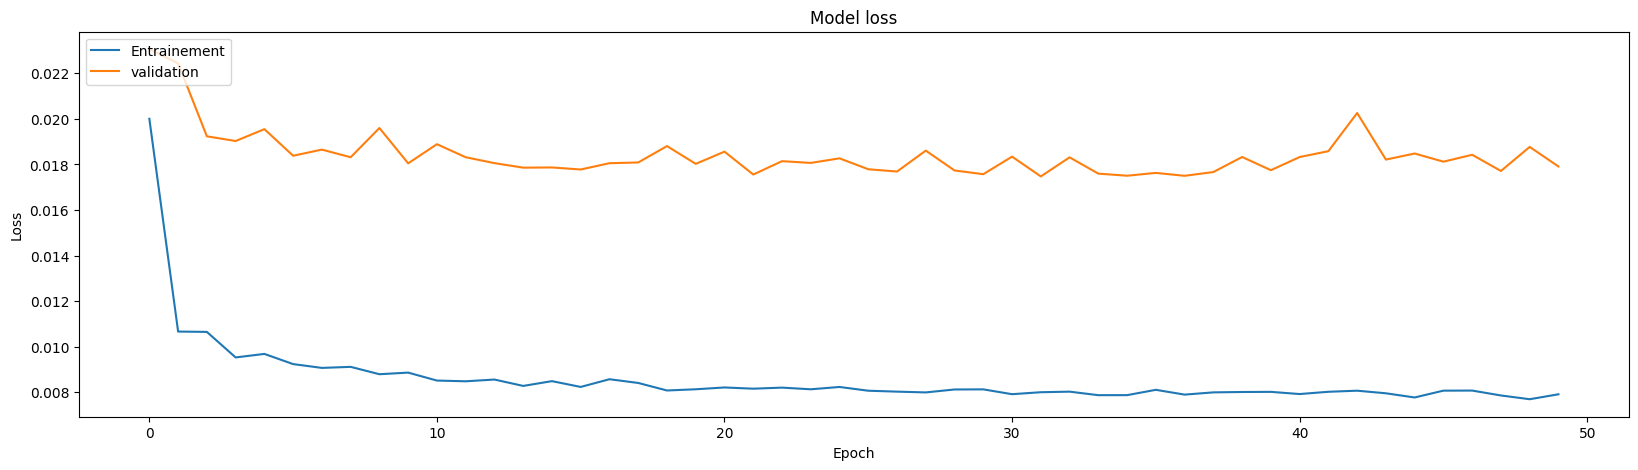

In [324]:
def ploter_Erreur(hist):
    f, axarr = plt.subplots(1,1, figsize=(20, 5))

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    axarr.set_title('Model loss')
    axarr.set_ylabel('Loss')
    axarr.set_xlabel('Epoch')
    axarr.legend(['Entrainement', 'validation'], loc='upper left')
    plt.show()
    
    
ploter_Erreur(model_train)

In [325]:

testPredict2=model.predict(Xtest)

mean_squared_error(Ytest, testPredict2)


29/29 [==============================] - 9s 16ms/step


0.028256001029448242

In [326]:
from sklearn.metrics import  r2_score
accurcy1 = r2_score(Ytest, testPredict2)
accurcy1

0.6527227551016834

In [327]:
import tensorflow as tf
from keras.layers import Layer
import keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context


In [328]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
# Define the model
inputs = Input(shape=(Xtrain.shape[1], 1))
lstm_out = Bidirectional(LSTM(units=200, return_sequences=True))(inputs)
dropout_1 = Dropout(0.2)(lstm_out)
attention_out = attention()(dropout_1)
outputs = Dense(1, activation='linear')(attention_out)
model2 = Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
model_train2 = model2.fit(Xtrain, Ytrain, validation_split=0.2, epochs=100,batch_size=64,callbacks=[early_stopping,reduce_lr],verbose=1)


Epoch 1/100
35/35 [==============================] - 22s 194ms/step - loss: 0.0249 - val_loss: 0.0325 - lr: 0.0010
Epoch 2/100
35/35 [==============================] - 5s 152ms/step - loss: 0.0127 - val_loss: 0.0239 - lr: 0.0010
Epoch 3/100
35/35 [==============================] - 4s 111ms/step - loss: 0.0100 - val_loss: 0.0262 - lr: 0.0010
Epoch 4/100
35/35 [==============================] - 4s 112ms/step - loss: 0.0099 - val_loss: 0.0252 - lr: 0.0010
Epoch 5/100
35/35 [==============================] - 4s 123ms/step - loss: 0.0102 - val_loss: 0.0205 - lr: 0.0010
Epoch 6/100
35/35 [==============================] - 4s 115ms/step - loss: 0.0097 - val_loss: 0.0210 - lr: 0.0010
Epoch 7/100
35/35 [==============================] - 5s 147ms/step - loss: 0.0090 - val_loss: 0.0196 - lr: 0.0010
Epoch 8/100
35/35 [==============================] - 4s 113ms/step - loss: 0.0092 - val_loss: 0.0211 - lr: 0.0010
Epoch 9/100
35/35 [==============================] - 5s 150ms/step - loss: 0.0087 - val

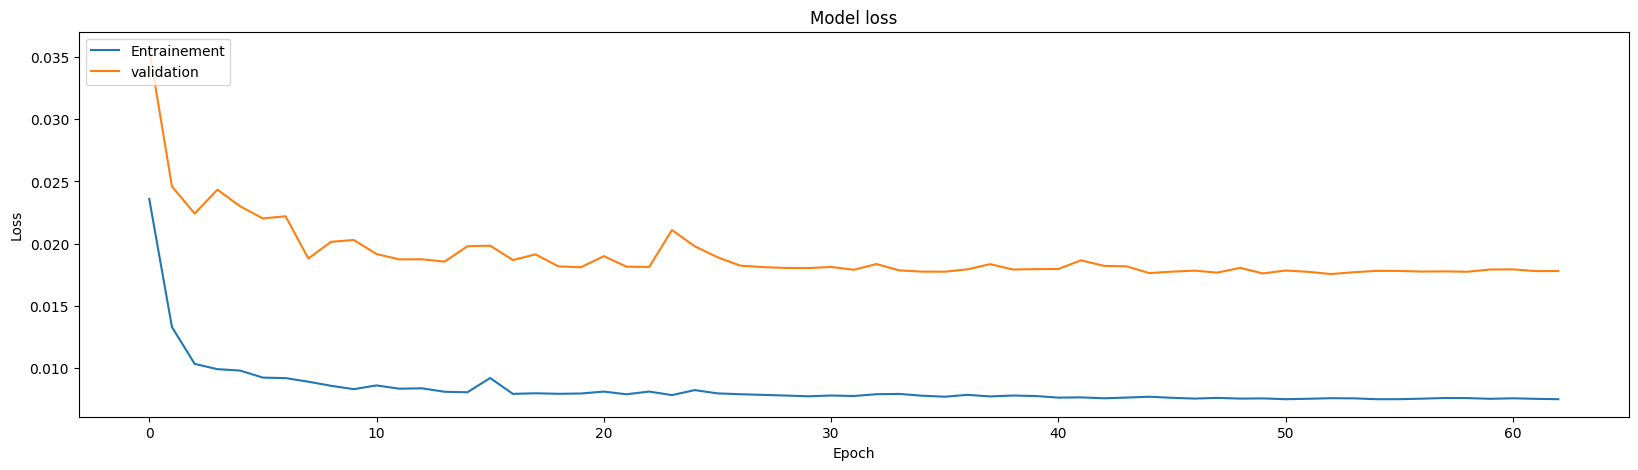

In [307]:
def ploter_Erreur(hist):
    f, axarr = plt.subplots(1,1, figsize=(20, 5))

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    axarr.set_title('Model loss')
    axarr.set_ylabel('Loss')
    axarr.set_xlabel('Epoch')
    axarr.legend(['Entrainement', 'validation'], loc='upper left')
    plt.show()
    
    
ploter_Erreur(model_train2)

In [308]:
testPredict3=model2.predict(Xtest)

mean_squared_error(Ytest, testPredict3)

29/29 [==============================] - 3s 34ms/step


0.025006051112414898

In [309]:
acurracy2 = r2_score(Ytest, testPredict3)
acurracy2

0.6926659038886828

In [288]:
train_mse_attn = model2.evaluate(Xtrain, Ytrain)
test_mse_attn = model2.evaluate(Xtest ,Ytest)
train_mse_attn1 = model.evaluate(Xtrain, Ytrain)
test_mse_attn1= model.evaluate(Xtest ,Ytest)
 
# Print error
print("Train set MSE LASTM+attention = ", train_mse_attn)
print("Test set MSE with LSTM+attention = ", test_mse_attn)
print("Train set MSE LSTM = ", train_mse_attn1)
print("Test set MSE  LSTM= ", test_mse_attn1)


29/29 [==============================] - 0s 12ms/step - loss: 0.0286
Train set MSE with attention =  0.009818349033594131
Test set MSE with attention =  0.024539945647120476
Train set MSE =  0.009457699954509735
Test set MSE  =  0.02858171984553337


In [330]:
print("accurcy de model lstm: ", accurcy1*100)
print("accurcy de model lstm+attention: ", acurracy2*100)

accurcy de model lstm:  65.27227551016834
accurcy de model lstm+attention:  69.26659038886828


In [329]:
train_mse_attn = model2.evaluate(Xtrain, Ytrain)
test_mse_attn = model2.evaluate(Xtest ,Ytest)
train_mse_attn1 = model.evaluate(Xtrain, Ytrain)
test_mse_attn1= model.evaluate(Xtest ,Ytest)
 
# Print error
print("Train set MSE LASTM+attention = ", train_mse_attn)
print("Test set MSE with LSTM+attention = ", test_mse_attn)
print("Train set MSE LSTM = ", train_mse_attn1)
print("Test set MSE  LSTM= ", test_mse_attn1)


29/29 [==============================] - 1s 17ms/step - loss: 0.0283
Train set MSE LASTM+attention =  0.009820266626775265
Test set MSE with LSTM+attention =  0.02479815110564232
Train set MSE LSTM =  0.009490836411714554
Test set MSE  LSTM=  0.028256002813577652


In [ ]:
plt.figure(figsize=(20, 10))

for year in data['Year'].unique():
    if year == 2023 :
        # output on black color:
        plt.plot(data[data['Year'] == year]['Energy(MW)'].values, label=year, color='black')
    else:
        plt.plot(data[data['Year'] == year]['Energy(MW)'].values, label=year)

plt.xlabel('Day')
plt.ylabel('MW Energy Captured')
plt.title('MW Energy Captured Over Multiple Years')
plt.legend()